#### \#MugLife

#### Step 0 : : Set up

In [1]:
from client import client
import pre_processing
import utils
import visualiser
import method

from praw.models import MoreComments

import string

import nltk 
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('vader_lexicon')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis.lda_model


import pandas as pd
from datetime import datetime
import ast

import os
from dotenv import load_dotenv

load_dotenv()

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/milindi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tokeniser = TweetTokenizer()
stemmer = nltk.stem.PorterStemmer()

# add punctuation to stopwords list
stop_words = stopwords.words('english') + list(string.punctuation) + ['rt', 'via', '...', '…', '"', "'", '`', '-', '..']

In [3]:
collected_posts = []
unprocessed_token_lists = []
processed_token_lists = []

posts_df = pd.DataFrame(columns=['social_media_id', 'title', 'utc_date', 'formatted_date', 'desc', 'author', 'rating','num_comments', 'unprocessed_tokens', 'processed_tokens'])

In [4]:
social_media_id = os.environ["SOCIAL-MEDIA-ID"]
social_media_id = social_media_id.lower()

collect_data_env = os.environ["COLLECT-DATA"]  

data_folder_path = os.environ["DATA-FOLDER-PATH"]

collect_data = True if collect_data_env == "True" else False

#### Step 1 : : Data collection

In [5]:
# Data collection from Reddit
data_sample_filepath = f'{data_folder_path}/data.csv'

if collect_data:
    subreddit_names = 'tea+coffee+TeaPorn+pourover'
    
    reddit_client = client()
    subreddit = reddit_client.subreddit(subreddit_names)
    collected_posts = [*subreddit.top(limit=None)] 

#### Step 2 : : Pre-processing and Exploration


In [6]:
# Create dataframe containing reddit post details, unprocessed and pre-processed token lists
# This bit extracts the data from reddit and saves it to the data file 
if collect_data:    
    for post in collected_posts:
        post_title = post.title
        post_description = post.selftext
        post_title_description = post_title + " " + post_description
        post_date = pd.to_datetime(datetime.fromtimestamp(post.created_utc).strftime("%d/%m/%Y"), format="%d/%m/%Y")
        
        unprocessed_tokens = tokeniser.tokenize(post_title_description)
        unprocessed_token_lists.append(unprocessed_tokens)
        
        processed_tokens = pre_processing.process(post_title_description, tokeniser, stemmer, stop_words, True)
        # text, tokeniser, stop_words
        processed_token_lists.append(processed_tokens)
        
        if post.author is None:
            post_author = 'None'
        else:
            post_author = post.author.name
            
        for comment in post.comments:
            if isinstance(comment, MoreComments):
                continue
    
            comment_text = comment.body if comment.body is None else ''
            
            unprocessed_comment_tokens = tokeniser.tokenize(comment_text)
            unprocessed_tokens = unprocessed_tokens + unprocessed_comment_tokens
            unprocessed_token_lists.append(unprocessed_comment_tokens)
            
            processed_comment_tokens = pre_processing.process(comment_text, tokeniser, stemmer, stop_words, False)
            processed_tokens = processed_tokens + processed_comment_tokens
            processed_token_lists.append(processed_comment_tokens)
            
        posts_df.loc[len(posts_df.index)] = [social_media_id, post_title, post.created_utc, post_date, post_description, post_author, post.upvote_ratio, post.num_comments, unprocessed_tokens, processed_tokens]
    
    # Read old data file if it exists to append new data collected, if not save new file
    old_posts_df = pd.DataFrame(columns=['social_media_id', 'title', 'utc_date', 'formatted_date', 'desc', 'author', 'rating','num_comments', 'unprocessed_tokens', 'processed_tokens'])
    
    if os.path.isfile(data_sample_filepath):
        old_posts_df = pd.read_csv(data_sample_filepath, header=0)

        posts_df = pd.concat([old_posts_df, posts_df], ignore_index=True)
    
    posts_df.to_csv(data_sample_filepath, index=False, header=True)

len(posts_df)



------------------------------------
Initial text
How do I use a coffee press? Do I have to grind the beans, or just put them directly into the coffee press? How would I use the coffee press if I want my coffee to use milk instead of water? Sorry if these questions are really basic, I'm a 13 year old trying to make my mom feel special on her birthday.

Edit: 

Thanks for the awards! I’ll give an update on whether my mom like the coffee after we celebrate.

------------------------------------




------------------------------------
Lowercase text

------------------------------------
how do i use a coffee press? do i have to grind the beans, or just put them directly into the coffee press? how would i use the coffee press if i want my coffee to use milk instead of water? sorry if these questions are really basic, i'm a 13 year old trying to make my mom feel special on her birthday.

edit: 

thanks for the awards! i’ll give an update on whether my mom like the coffee after we celebra

10

In [7]:
# Read data from file
if not collect_data: 
    posts_df = pd.read_csv(data_sample_filepath)
    unprocessed_token_lists = posts_df.unprocessed_tokens.apply(lambda s: list(ast.literal_eval(s)))
    posts_df['unprocessed_tokens'] = unprocessed_token_lists
    processed_token_lists = posts_df.processed_tokens.apply(lambda s: list(ast.literal_eval(s)))
    posts_df['processed_tokens'] = processed_token_lists
    
    posts_df['formatted_date'] = pd.to_datetime(posts_df['formatted_date'], format="%Y/%m/%d")

posts_df

,social_media_id,title,utc_date,formatted_date,desc,author,rating,num_comments,unprocessed_tokens,processed_tokens
0,reddit,How do I use a coffee press?,1.570577e+09,2019-10-09,"Do I have to grind the beans, or just put them...",Android_Is_Great,0.99,366,"[How, do, I, use, a, coffee, press, ?, Do, I, ...","[use, coffee, press, grind, beans, put, direct..."
1,reddit,Official statement from the US Embassy on the ...,1.706109e+09,2024-01-25,,AnEriksenWife,0.95,806,"[Official, statement, from, the, US, Embassy, ...","[official, statement, us, embassy, latest, tea..."
2,reddit,Perfect job doesn't exi-,1.518607e+09,2018-02-14,,dinnno13,0.95,109,"[Perfect, job, doesn't, exi, -]","[perfect, job, exi]"
3,reddit,One thing coffee and tea drinkers can agree on...,1.476697e+09,2016-10-17,,saltyteabag,0.89,427,"[One, thing, coffee, and, tea, drinkers, can, ...","[one, thing, coffee, tea, drinkers, agree, coc..."
4,reddit,子冶石瓢全手工制作过程演示#宜兴紫砂#紫砂壶#中国匠人,1.599134e+09,2020-09-03,,Zishateapot,1.00,317,"[子冶石瓢全手工制作过程演示, #宜兴紫砂, #紫砂壶, #中国匠人]",[]
5,reddit,4chan's Beginners Guide on Tea,1.491397e+09,2017-04-05,,Gibbonja,0.90,379,"[4chan, ', s, Beginners, Guide, on, Tea]","[4chan, beginners, guide, tea]"
6,reddit,Hilarious yet true,1.608134e+09,2020-12-17,,mentel42,0.99,180,"[Hilarious, yet, true]","[hilarious, yet, true]"
7,reddit,It didn't impress my girlfriend (she says I ha...,1.598545e+09,2020-08-28,,Kaiped1000,0.99,230,"[It, didn't, impress, my, girlfriend, (, she, ...","[impress, girlfriend, says, problem, thought, ..."
8,reddit,My buddies like the warmth,1.489830e+09,2017-03-18,,vanyanovich,0.97,95,"[My, buddies, like, the, warmth]","[buddies, like, warmth]"
9,reddit,a peaceful sketch,1.599315e+09,2020-09-06,,devbang,1.00,58,"[a, peaceful, sketch]","[peaceful, sketch]"


In [8]:
total_num_posts = len(posts_df)
print(f'Total number of posts: {total_num_posts}')

Total number of posts: 10


In [9]:
total_num_comments = posts_df['num_comments'].sum()
print(f'Total number of comments: {total_num_comments}')

Total number of comments: 2967


In [10]:
total_data_items = total_num_posts + total_num_comments
print(f'Total data items: {total_data_items}')

Total data items: 2977


-----------------
Term frequency
-----------------

the: 8
I: 6
coffee: 6
my: 5
on: 5
.: 5
a: 4
tea: 4
use: 3
press: 3
?: 3
to: 3
How: 2
have: 2
,: 2
if: 2
are: 2
mom: 2
like: 2
-: 2
drinkers: 2
do: 1
Do: 1
grind: 1
beans: 1
or: 1
just: 1
put: 1
them: 1
directly: 1
into: 1
would: 1
want: 1
milk: 1
instead: 1
of: 1
water: 1
Sorry: 1
these: 1
questions: 1
really: 1
basic: 1
I'm: 1
13: 1
year: 1
old: 1
trying: 1
make: 1
feel: 1
special: 1
----------------------------------


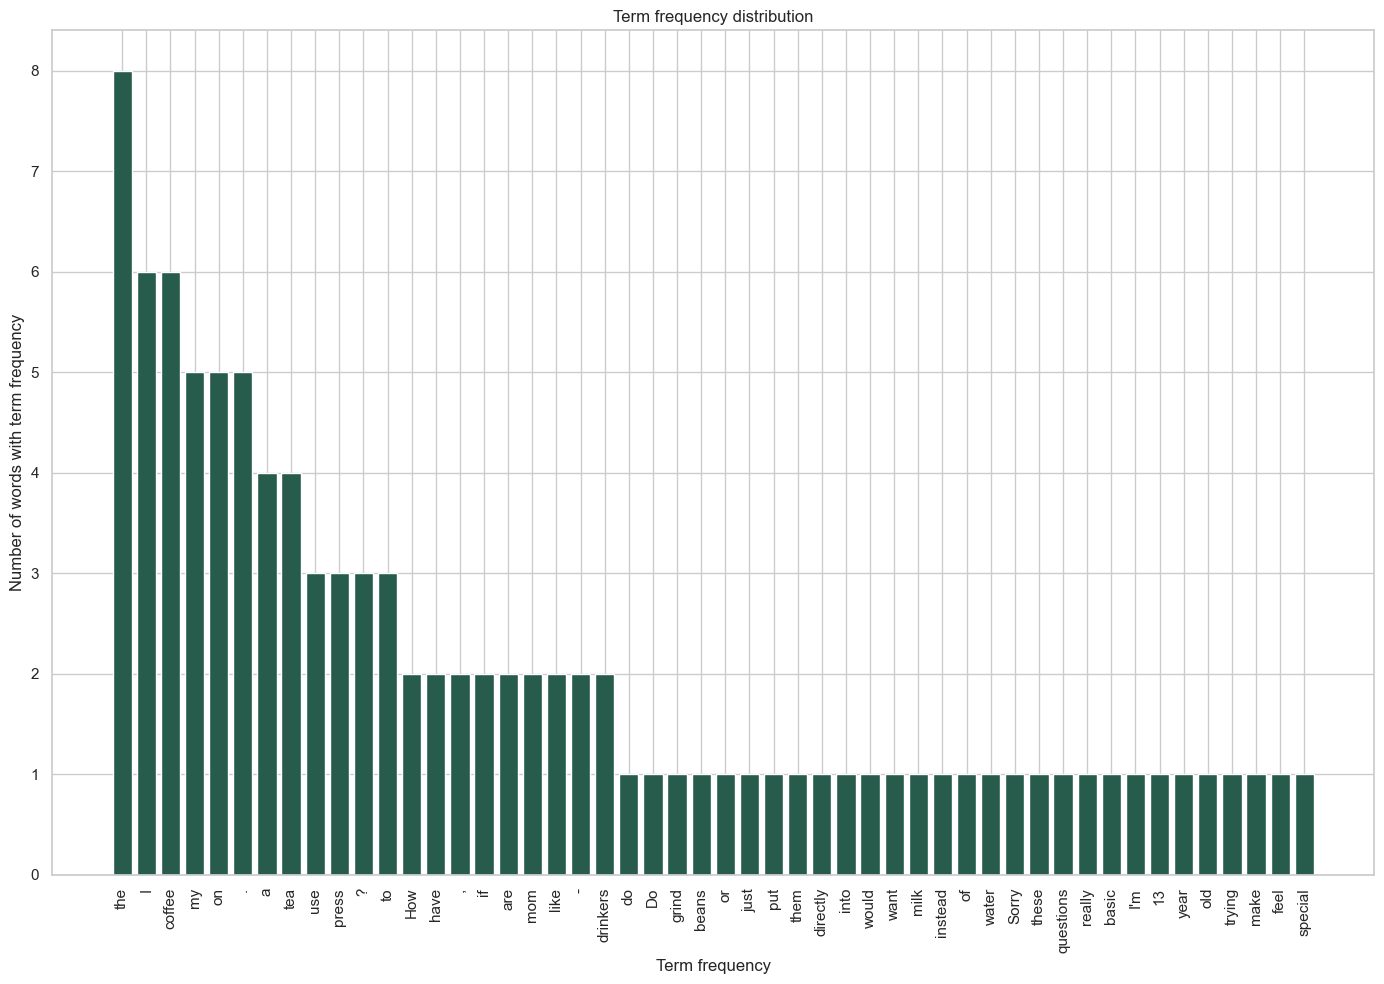

In [11]:
flatted_unprocessed_token_list = [element for innerList in unprocessed_token_lists for element in innerList]   

visualiser.compute_term_freq(flatted_unprocessed_token_list, True)

-----------------
Term frequency
-----------------

coffee: 6
tea: 4
use: 3
press: 3
mom: 2
like: 2
drinkers: 2
grind: 1
beans: 1
put: 1
directly: 1
would: 1
want: 1
milk: 1
instead: 1
water: 1
sorry: 1
questions: 1
really: 1
basic: 1
i'm: 1
year: 1
old: 1
trying: 1
make: 1
feel: 1
special: 1
birthday: 1
edit: 1
thanks: 1
awards: 1
ill: 1
give: 1
update: 1
whether: 1
celebrate: 1
official: 1
statement: 1
us: 1
embassy: 1
latest: 1
controversy: 1
perfect: 1
job: 1
exi: 1
one: 1
thing: 1
agree: 1
cocoa: 1
plebs: 1
----------------------------------


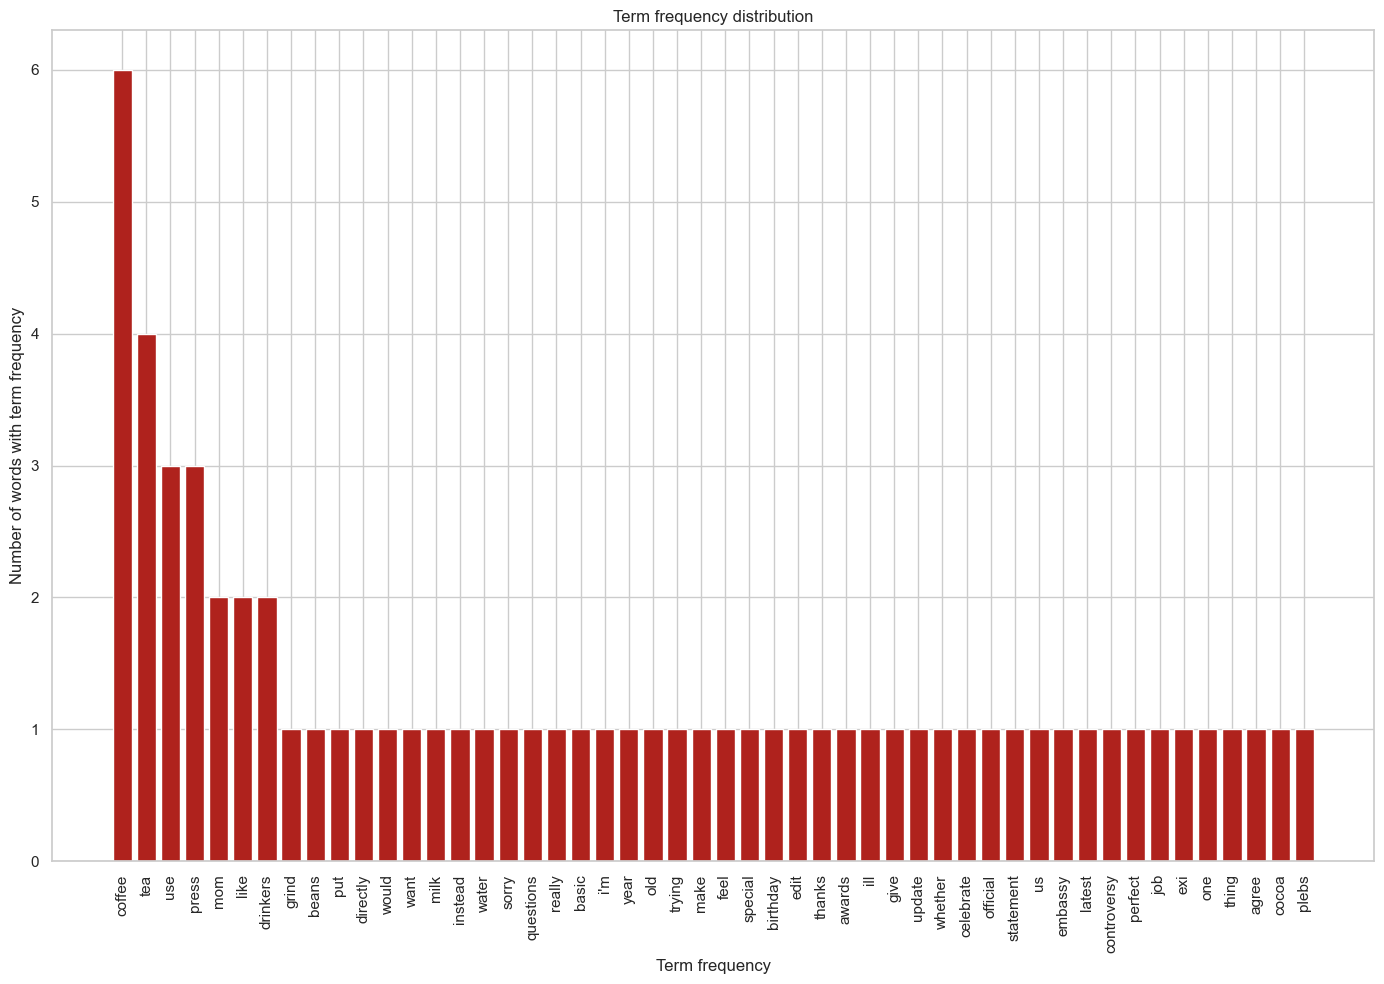

In [12]:
processed_token_lists = [element for innerList in processed_token_lists for element in innerList]   

visualiser.compute_term_freq(processed_token_lists, True, utils.red)

#### Step 3 : : Method

Methods explored:
1. N-grams were explored to gain preliminary understanding of the sentiments in this subreddit
2. Sentiment analysis via N-grams, Count and Vader techniques 
3. Topic modelling via LDA topic model

In [13]:
# N-grams
top_50_bi_grams =  nltk.collocations.BigramCollocationFinder.from_words(processed_token_lists).ngram_fd.most_common(50)
top_50_tri_grams = nltk.collocations.TrigramCollocationFinder.from_words(processed_token_lists).ngram_fd.most_common(50)

In [14]:
# Sentiment analysis
count_sentiment_list = method.sentiment_analysis('Count', posts_df)



------------Analysing sentiment------------
Date: 2019-10-09 00:00:00

Post title:
How do I use a coffee press?

Post desc:
Do I have to grind the beans, or just put them directly into the coffee press? How would I use the coffee press if I want my coffee to use milk instead of water? Sorry if these questions are really basic, I'm a 13 year old trying to make my mom feel special on her birthday.

Edit: 

Thanks for the awards! I’ll give an update on whether my mom like the coffee after we celebrate.

Num Comments: 366
------------------------------------

use, coffee, press, grind, beans, put, directly, coffee, press, would, use, coffee, press, want, coffee, use, milk, instead, water, sorry, questions, really, basic, i'm, year, old, trying, make, mom, feel, special, birthday, edit, thanks, awards, ill, give, update, whether, mom, like, coffee, celebrate, 

------------Count sentiment value------------
1
------------------------------------



------------Analysing sentiment----------

In [15]:
vader_sentiment_list = method.sentiment_analysis('Vader', posts_df)



------------Analysing sentiment------------
Date: 2019-10-09 00:00:00

Post title:
How do I use a coffee press?

Post desc:
Do I have to grind the beans, or just put them directly into the coffee press? How would I use the coffee press if I want my coffee to use milk instead of water? Sorry if these questions are really basic, I'm a 13 year old trying to make my mom feel special on her birthday.

Edit: 

Thanks for the awards! I’ll give an update on whether my mom like the coffee after we celebrate.

Num Comments: 366
------------------------------------

use, coffee, press, grind, beans, put, directly, coffee, press, would, use, coffee, press, want, coffee, use, milk, instead, water, sorry, questions, really, basic, i'm, year, old, trying, make, mom, feel, special, birthday, edit, thanks, awards, ill, give, update, whether, mom, like, coffee, celebrate


------------Count sentiment value------------
neg: 0.074
------------------------------------

use, coffee, press, grind, beans, p

In [16]:
# Topic modelling
num_topic = 10
num_features = 1500

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=num_features, stop_words='english')
tf = tf_vectorizer.fit_transform(processed_token_lists)

tf_feature_names = tf_vectorizer.get_feature_names_out()

lda_model = LatentDirichletAllocation(n_components=num_topic, max_iter=10, learning_method='online').fit(tf)
    

In [21]:
# Graphs and networks => Egonet

# get the top author/s from the posts 
posts_df_by_rating = posts_df.sort_values(['rating', 'num_comments'], ascending=[False, False])
posts_df_by_rating_filtered = posts_df_by_rating[posts_df_by_rating['author'] != 'None']
subset_top_rated_authors_df = posts_df_by_rating_filtered.head(1)

print('------------Ego graph exploration------------\n')
ego_graph_list = []
for row in subset_top_rated_authors_df.itertuples():
    author_name = row.author   
    social_media_id = row.social_media_id
    
    print(utils.yellow_rgb + f'Social media id: {social_media_id}\n', end='')
    print(utils.yellow_rgb + f'Author name: {author_name}\nAuthor rating: {row.rating}\nAuthor comments: {row.num_comments}\n', end='')
    
    if social_media_id == 'reddit':
        ego = reddit_client.redditor(author_name)
        ego_name = ego.name
        ego_graph = method.construct_ego_graph(reddit_client, ego, ego_name)
        ego_graph_list.append({'ego_graph': ego_graph, 'ego_name': ego_name})
        
        # Note: print_ego_graph does not depend on the social media used
        utils.print_ego_graph(data_folder_path, ego_graph, ego_name)
        
subset_top_rated_authors_df  

------------Ego graph exploration------------

Social media id: reddit
Author name: Zishateapot
Author rating: 1.0
Author comments: 317
Ego name:
Zishateapot

In degree of ego:
125
Out degree of ego:
7In neighbours of ego:
{Zishateapot, Darkman013, MemeMaven, Canvasdancer, E1ghtbit, ihamn, georgefahd, ohshuckz, DogOnABike, Tom6187, error_museum, TheFoxIsLost, im_plant_Boredom, PoppaPelly, SonicCephalopod, Handyandy58, KeruxDikaios, InLoveWithInternet, FhD89, Angelita0026, CameronFLSTC, sept27, AdultLearner123ABC, veliest420, laruhh, TangerineTardigrade, QuadZebra883, KansasBrewista, TheMachinesWay, Heor326, MrGramGram, rowenajordana, MajorDFekt, tenorsaxhero, su2dv, blodorn, userdfh, kassi0peia, SuPurrrrNova, twlefty, Cowarddd, Greenobserver, ogfuelbone12, fstop570, harrionparrix, Tonysreptile, Rocketfemme, wanchiz, LivingCommunication5, NicoleP1975, horror_etc, darkskys100, palming-my-butt, The-Dead-Dont-Die, Doctor_Deceptive, wheninrome91, popcornglasses, fight_for_anything, QFugp6II

,social_media_id,title,utc_date,formatted_date,desc,author,rating,num_comments,unprocessed_tokens,processed_tokens
4,reddit,子冶石瓢全手工制作过程演示#宜兴紫砂#紫砂壶#中国匠人,1.599134e+09,2020-09-03,,Zishateapot,1.0,317,"[子冶石瓢全手工制作过程演示, #宜兴紫砂, #紫砂壶, #中国匠人]",[]


#### Step 4 : : Analysis

Questions to explore:
1. Which is the superior beverage?
2. What are the most talked topics?
3. Which parts of the world favour which bev? What are their feelings and opinions?
4. Since we're in Melbourne, maybe a special look into Melbourne?
5. Spike in engagement of people with sales and deals; limited time events, world tea/coffee days, variation of engagement with change of season -- Event and correlations 
6. Origin of tea/ coffee
7. Benefits people get from tea/ coffee

In [22]:
# n-grams
top_50_bi_grams

[(('coffee', 'press'), 3),
 (('use', 'coffee'), 2),
 (('press', 'grind'), 1),
 (('grind', 'beans'), 1),
 (('beans', 'put'), 1),
 (('put', 'directly'), 1),
 (('directly', 'coffee'), 1),
 (('press', 'would'), 1),
 (('would', 'use'), 1),
 (('press', 'want'), 1),
 (('want', 'coffee'), 1),
 (('coffee', 'use'), 1),
 (('use', 'milk'), 1),
 (('milk', 'instead'), 1),
 (('instead', 'water'), 1),
 (('water', 'sorry'), 1),
 (('sorry', 'questions'), 1),
 (('questions', 'really'), 1),
 (('really', 'basic'), 1),
 (('basic', "i'm"), 1),
 (("i'm", 'year'), 1),
 (('year', 'old'), 1),
 (('old', 'trying'), 1),
 (('trying', 'make'), 1),
 (('make', 'mom'), 1),
 (('mom', 'feel'), 1),
 (('feel', 'special'), 1),
 (('special', 'birthday'), 1),
 (('birthday', 'edit'), 1),
 (('edit', 'thanks'), 1),
 (('thanks', 'awards'), 1),
 (('awards', 'ill'), 1),
 (('ill', 'give'), 1),
 (('give', 'update'), 1),
 (('update', 'whether'), 1),
 (('whether', 'mom'), 1),
 (('mom', 'like'), 1),
 (('like', 'coffee'), 1),
 (('coffee',

In [23]:
top_50_tri_grams

[(('use', 'coffee', 'press'), 2),
 (('coffee', 'press', 'grind'), 1),
 (('press', 'grind', 'beans'), 1),
 (('grind', 'beans', 'put'), 1),
 (('beans', 'put', 'directly'), 1),
 (('put', 'directly', 'coffee'), 1),
 (('directly', 'coffee', 'press'), 1),
 (('coffee', 'press', 'would'), 1),
 (('press', 'would', 'use'), 1),
 (('would', 'use', 'coffee'), 1),
 (('coffee', 'press', 'want'), 1),
 (('press', 'want', 'coffee'), 1),
 (('want', 'coffee', 'use'), 1),
 (('coffee', 'use', 'milk'), 1),
 (('use', 'milk', 'instead'), 1),
 (('milk', 'instead', 'water'), 1),
 (('instead', 'water', 'sorry'), 1),
 (('water', 'sorry', 'questions'), 1),
 (('sorry', 'questions', 'really'), 1),
 (('questions', 'really', 'basic'), 1),
 (('really', 'basic', "i'm"), 1),
 (('basic', "i'm", 'year'), 1),
 (("i'm", 'year', 'old'), 1),
 (('year', 'old', 'trying'), 1),
 (('old', 'trying', 'make'), 1),
 (('trying', 'make', 'mom'), 1),
 (('make', 'mom', 'feel'), 1),
 (('mom', 'feel', 'special'), 1),
 (('feel', 'special', 'bi

Number of posts per date ordered:
  formatted_date  count
0     2016-10-17      1
1     2017-03-18      1
2     2017-04-05      1
3     2018-02-14      1
4     2019-10-09      1


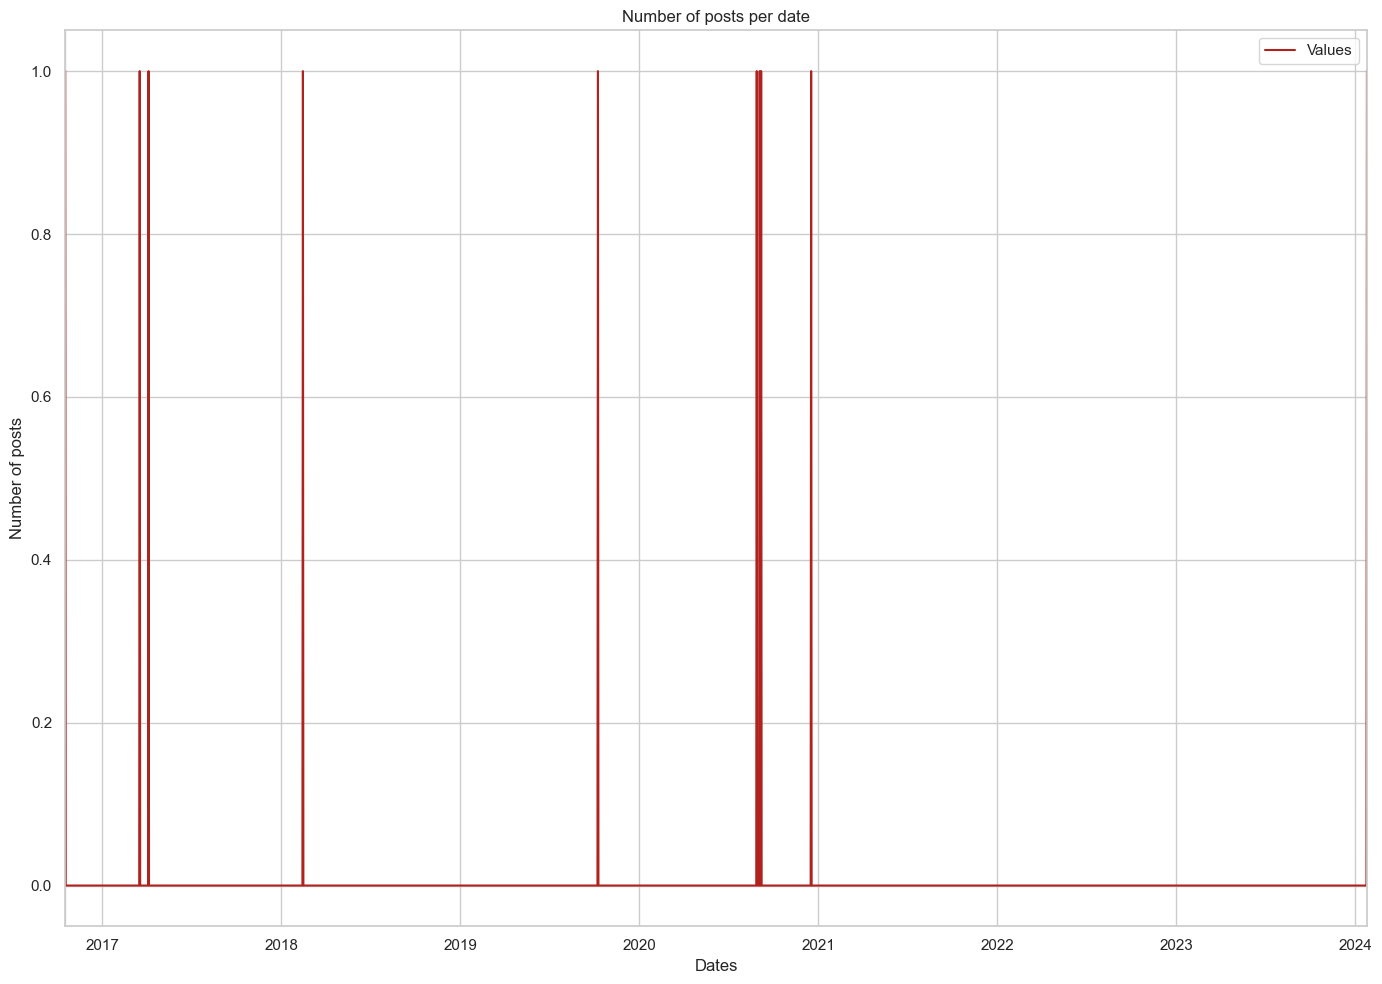

In [24]:
# Posts per date
num_posts_per_date = posts_df.groupby('formatted_date')['title'].count()
visualiser.display_time_series_stats(num_posts_per_date, 'count', 'Number of posts per date', 'Dates', 'Number of posts', utils.red)

Posts per author:
             author  count
0     AnEriksenWife      1
1  Android_Is_Great      1
2          Gibbonja      1
3        Kaiped1000      1
4       Zishateapot      1


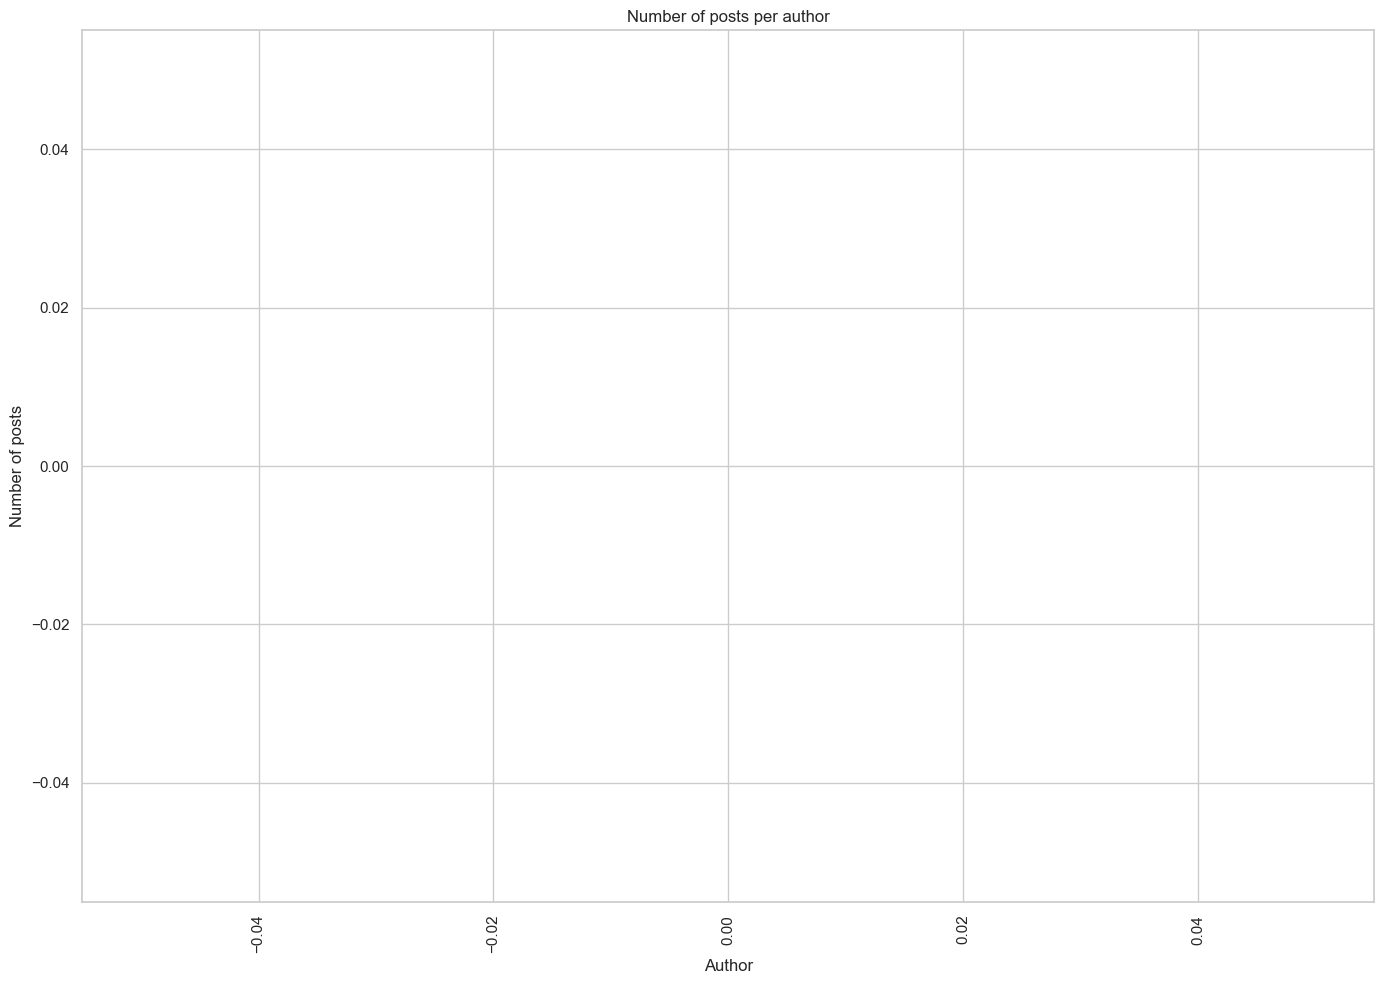

In [25]:
# Posts per author
# Displaying authors with only more than 1 post
num_posts_per_author = posts_df.groupby('author')['title'].count()

num_posts_per_author_ordered = num_posts_per_author.reset_index(name='count').sort_values(['count'], ascending=False)
print(f'Posts per author:\n{num_posts_per_author_ordered.head()}')

filtered_df = num_posts_per_author_ordered[num_posts_per_author_ordered['count'] > 5 ]
filtered_df = filtered_df[filtered_df['author'] != 'None']

num_posts_per_author_y = filtered_df['count']
author_x = filtered_df['author']
visualiser.generate_bar_chart(author_x, num_posts_per_author_y, utils.red, 'Number of posts per author', 'Author', 'Number of posts')

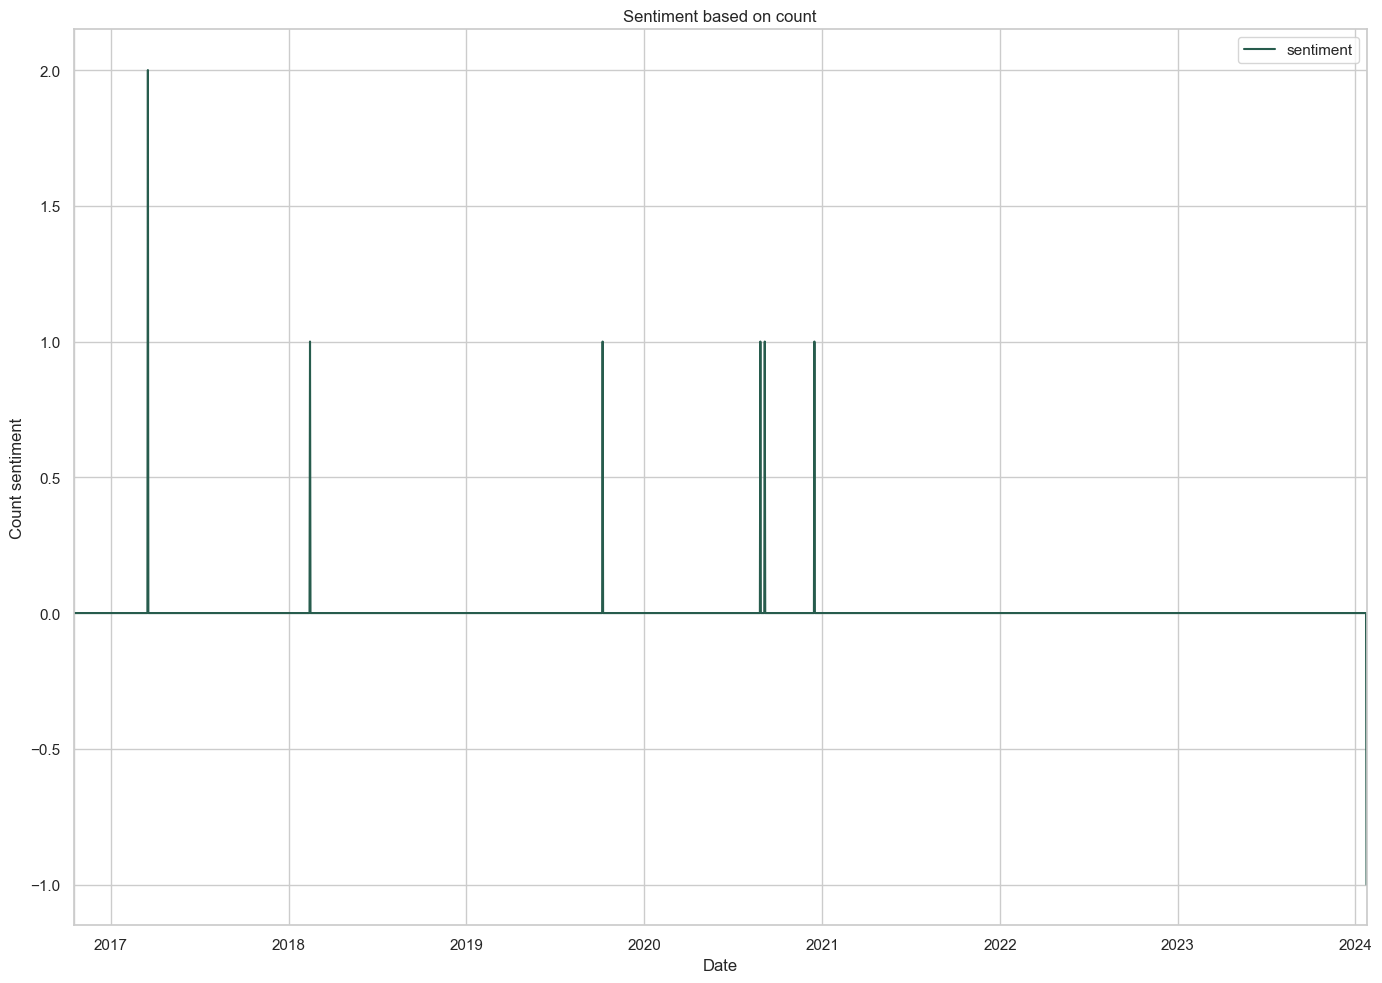

In [26]:
# Sentiment analysis
# Count
visualiser.generate_time_series(count_sentiment_list, 'Sentiment based on count', 'date', 'sentiment', 'Date', 'Count sentiment', utils.green)

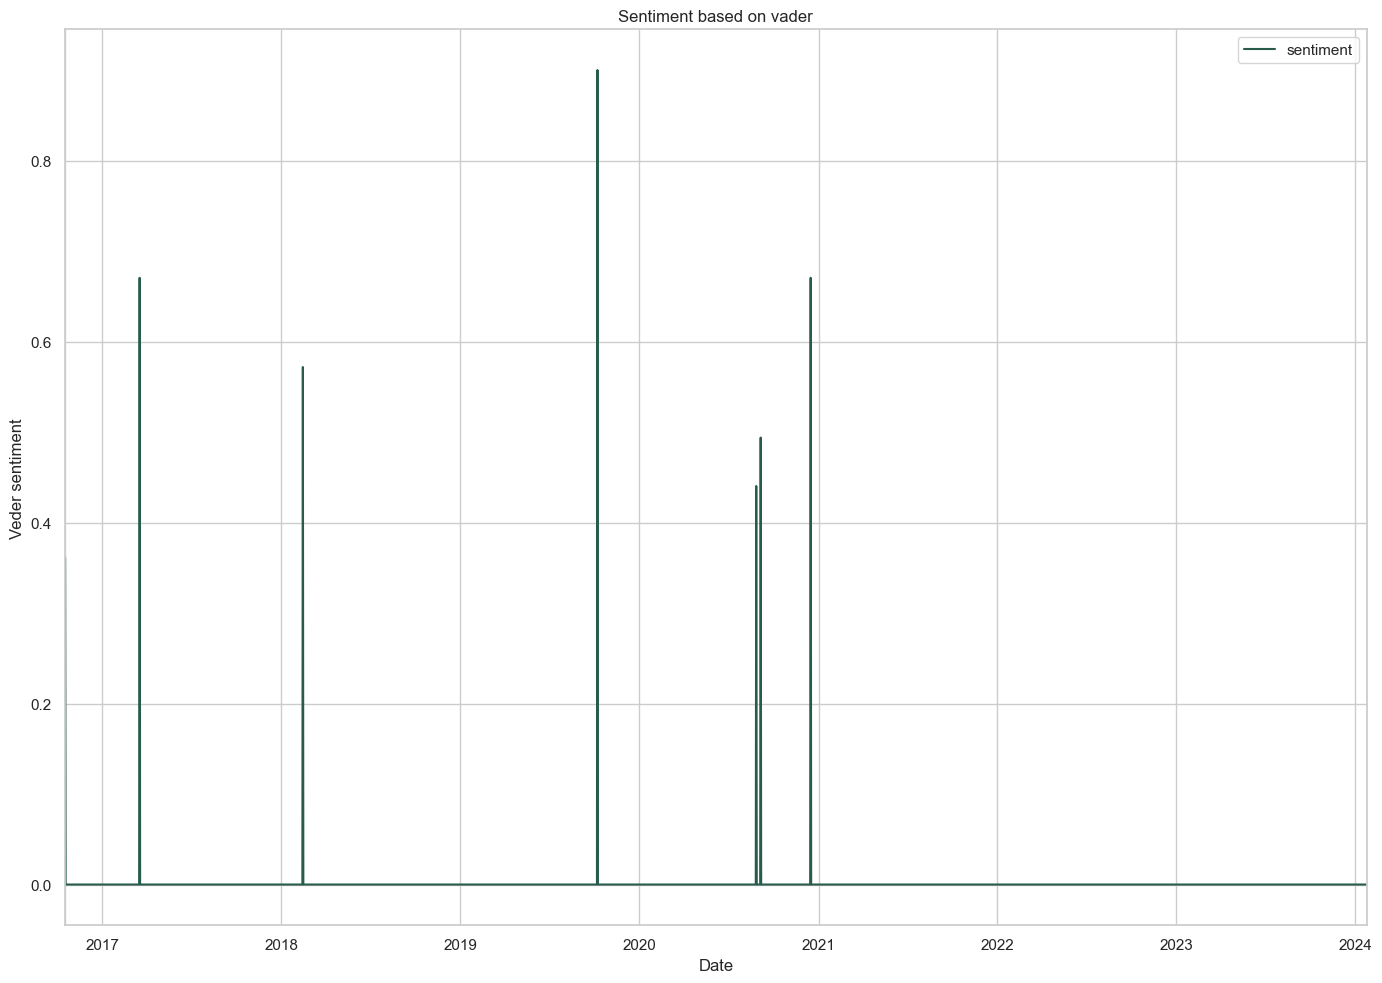

In [27]:
# Vader
visualiser.generate_time_series(vader_sentiment_list, 'Sentiment based on vader', 'date', 'sentiment', 'Date', 'Veder sentiment', utils.green)

In [28]:
# Topic modelling
max_word_count_to_display = 15
visualiser.display_topics(lda_model, tf_feature_names, max_word_count_to_display)

Topic 0:
coffee drinkers tea like use press mom
Topic 1:
tea press use mom like drinkers coffee
Topic 2:
mom coffee use tea drinkers like press
Topic 3:
like coffee tea press mom drinkers use
Topic 4:
mom coffee drinkers press use like tea
Topic 5:
mom coffee drinkers press like use tea
Topic 6:
use drinkers tea mom press coffee like
Topic 7:
drinkers mom press coffee use tea like
Topic 8:
use like press mom coffee tea drinkers
Topic 9:
like drinkers press coffee mom tea use


In [29]:
# pyLDAvis
panel = pyLDAvis.lda_model.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
pyLDAvis.enable_notebook()
pyLDAvis.display(panel)

/Users/milindi/Documents/Honours/SMNA/MugLife/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=27930) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/milindi/Documents/Honours/SMNA/MugLife/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=27930) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/milindi/Documents/Honours/SMNA/MugLife/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=27930) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/milindi/Documents/Honours/SMNA/MugLife/venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=27930) is multi-threaded, use of fork() may lead to deadlo

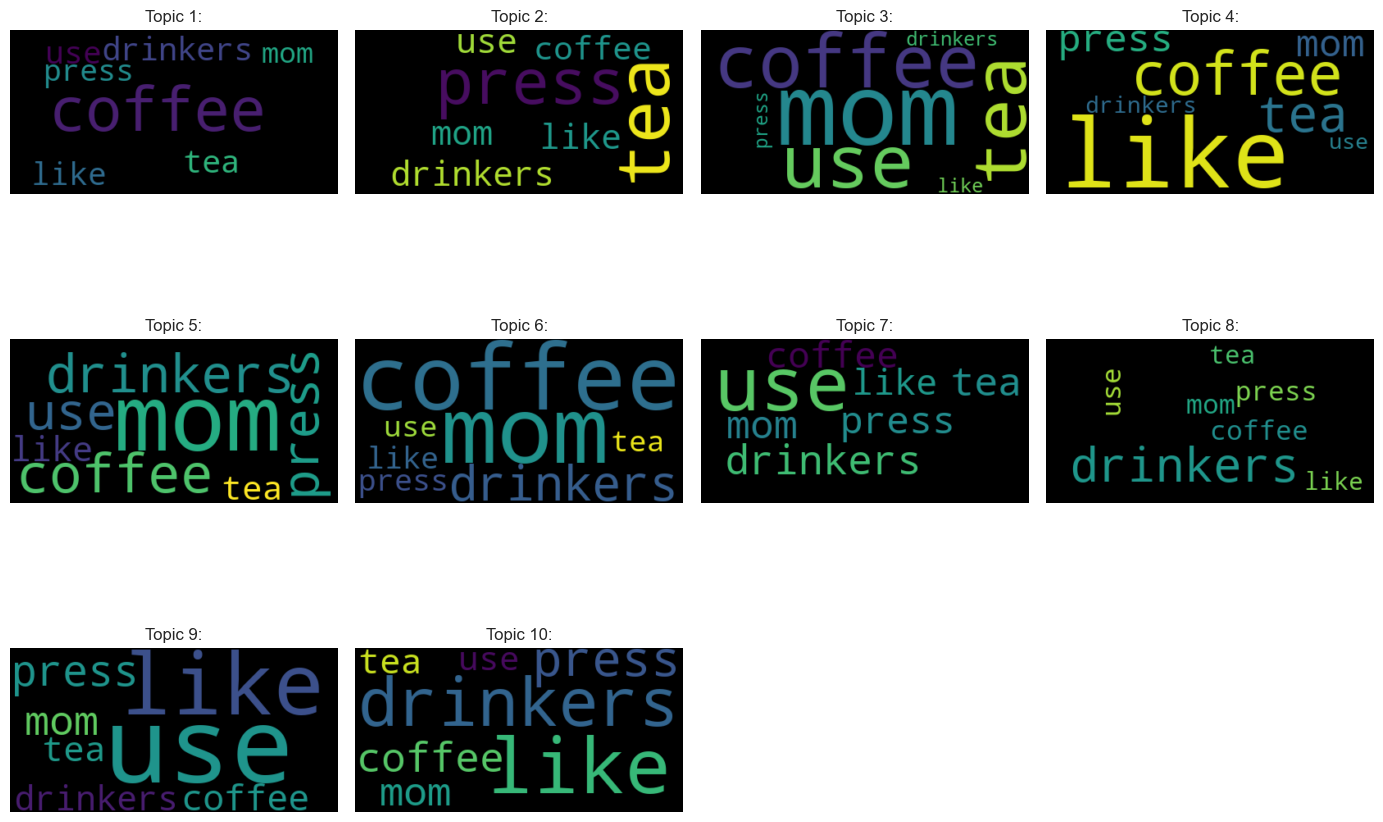

In [30]:
# wordcloud
visualiser.display_word_cloud(lda_model, tf_feature_names)

Ego name: Zishateapot


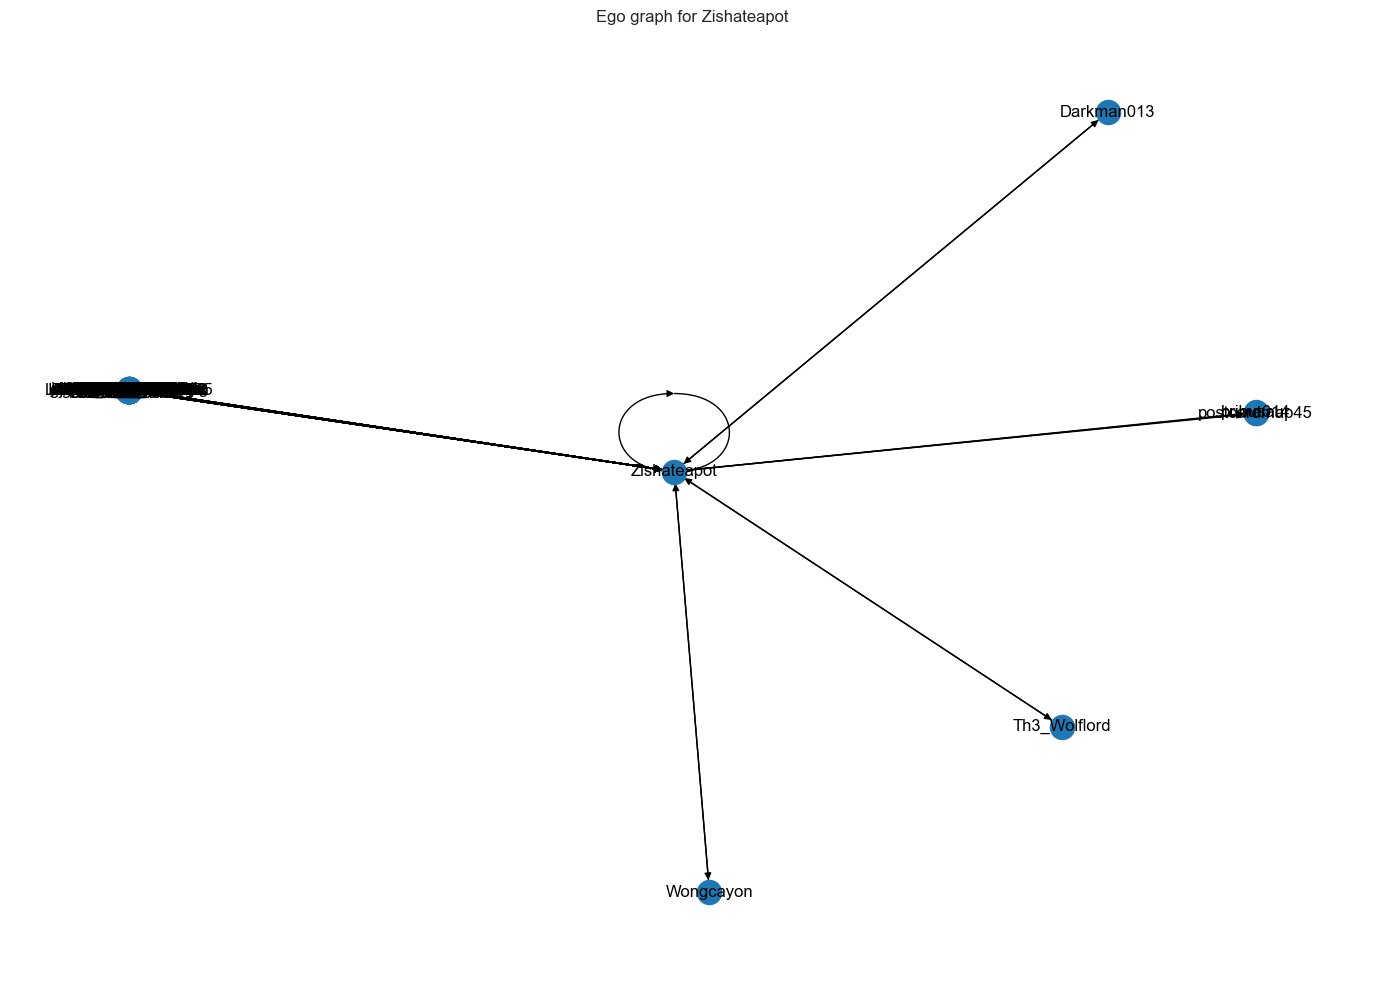

In [31]:
# Display the ego graphs for the top users

for item in ego_graph_list:
    ego_graph = item.get('ego_graph')
    ego_name = item.get('ego_name')
    print(f'Ego name: {ego_name}\n\n')
    visualiser.display_ego_graph(ego_graph, ego_name)